# Plotting Results

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from train import *
import os
import datetime
from collections import Counter
from itertools import product
import random
import matplotlib.pyplot as plt
import statistics
import optuna
from sklearn.model_selection import cross_val_score
from scipy.sparse import csr_matrix, save_npz, load_npz
import joblib
import shap
shap.initjs()

Added "Arial" font to matplotlib.

In [2]:
import matplotlib.font_manager
matplotlib.font_manager.fontManager.addfont("/home/materialsinformatics/anaconda3/envs/py39torch/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams['figure.subplot.bottom'] = 0.2 # 見切れ防止
plt.rcParams['figure.subplot.left'] = 0.2 # 見切れ防止
plt.rcParams['font.family'] ='Arial'#使用するフォント
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 18 #フォントの大きさ
plt.figure(figsize=(4,4))

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

# Distribution of PCE(y)

In [4]:
y = pd.read_csv("data/raw/Perovskite_36937data.csv")["JV_default_PCE"]
y_all = pd.read_csv("data/raw/Perovskite_database_content_all_data.csv")["JV_default_PCE"]

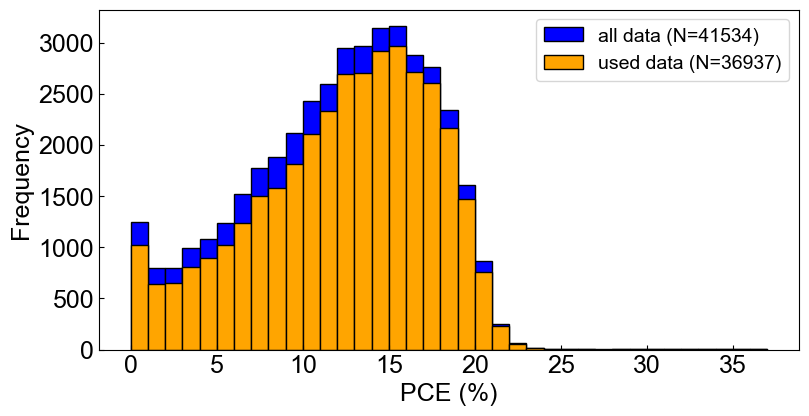

In [5]:
plt.figure(figsize=(10,5))
plt.hist(y_all,bins=37,range=(0, 37), rwidth=1,edgecolor="black",color='blue', label='all data (N=41534)')
plt.hist(y,bins=37,range=(0, 37), rwidth=1,edgecolor="black",color='orange', label='used data (N=36937)')
plt.rcParams['font.size'] = 14
plt.xlabel("PCE (%)")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("PCE_41534_36937_hist_mod.png",dpi=300)

In [16]:
print(y_all.describe())
print(y.describe())

count    41534.000000
mean        12.031021
std          5.229670
min          0.000000
25%          8.470000
50%         12.730000
75%         16.100000
max         36.200000
Name: JV_default_PCE, dtype: float64
count    36937.000000
mean        12.263254
std          5.144724
min          0.000000
25%          8.900000
50%         13.000000
75%         16.240000
max         36.200000
Name: JV_default_PCE, dtype: float64


In [6]:
def vec2csr(vec, csr_file_name, columns_file_name):
    csr = csr_matrix(vec)
    save_npz(csr_file_name, csr)
    if columns_file_name != None:
        columns_arr = np.array(vec.columns)
        np.save(columns_file_name, columns_arr)
def csr2vec(csr_file_name, columns_file_name):
    if columns_file_name == None:
        vec = load_npz(csr_file_name).toarray()
    else:
        vec = pd.DataFrame(load_npz(csr_file_name).toarray(),
             columns=np.load(columns_file_name,allow_pickle=True))
    return vec

In [10]:
def jointplot(use_X, model, split, prop, fill, rs):
    train = pd.read_csv(f"data/model/regression/{use_X}_Train_{model}_{split}_{prop}_{fill}_r{rs}.csv")
    test = pd.read_csv(f"data/model/regression/{use_X}_Predict_{model}_{split}_{prop}_{fill}_r{rs}.csv")
    train[" "] = "train"
    train.rename(columns = {'y_train_real': 'Experimental PCE (%)','y_train_pred': 'Predicted PCE (%)'},
                inplace = True)
    test[" "] = "test"
    test.rename(columns = {'y_test_real': 'Experimental PCE (%)','y_test_pred': 'Predicted PCE (%)'},
                inplace = True)
    stack = pd.concat([train,test]).reset_index()
    plt.rcParams['font.family'] ='Arial'
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['font.size'] = 18
    fig = sns.jointplot(x=stack["Experimental PCE (%)"], y=stack["Predicted PCE (%)"], hue=stack[" "],joint_kws={'alpha': 0.3},edgecolor='white')
    handles, labels = fig.ax_joint.get_legend_handles_labels()
    fig.ax_joint.legend(handles, labels)
    plt.plot([stack["Experimental PCE (%)"].min(), stack["Experimental PCE (%)"].max()], [stack["Experimental PCE (%)"].min(), stack["Experimental PCE (%)"].max()], c="black")
    plt.locator_params(axis='x',nbins=10)
    plt.locator_params(axis='y',nbins=10)
    plt.xlim([stack["Experimental PCE (%)"].min()-2, stack["Experimental PCE (%)"].max()+2])
    plt.ylim([stack["Experimental PCE (%)"].min()-2, stack["Experimental PCE (%)"].max()+2])
    plt.savefig(f"data/model/regression/jointplot_{use_X}_{model}_{split}_{prop}_{fill}_r{rs}.png", dpi=300)

In [11]:
def errorplot_train_ec(use_X, model, split, prop, fill, rs):
    train = pd.read_csv(f"data/model/regression/{use_X}_Train_{model}_{split}_{prop}_{fill}_r{rs}.csv")
    test = pd.read_csv(f"data/model/regression/{use_X}_Predict_{model}_{split}_{prop}_{fill}_r{rs}.csv")
    y_test_real = test["y_test_real"]
    y_test_pred = test["y_test_pred"]
    y_train_real = train["y_train_real"]
    y_train_pred = train["y_train_pred"]  
    y_error_train = y_train_pred-y_train_real
    y_error_test = y_test_pred-y_test_real
    plt.figure(figsize=(4,4))
    plt.scatter(y_train_real, y_error_train, alpha=0.3, c="#1f77b4",  label="train",ec='white', linewidths=0.5)
    plt.plot([y_train_real.min(), y_train_real.max()], [0, 0], c="black")
    plt.rcParams['font.family'] ='Arial'
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['font.size'] = 14
    plt.xlabel("Experimental PCE (%)", labelpad =1)
    plt.ylabel("Error (%)", labelpad =1)
    plt.locator_params(axis='x',nbins=6)
    plt.locator_params(axis='y',nbins=6)
    plt.ylim(-22, 22)
    plt.legend(edgecolor='black')
    plt.rcParams['figure.subplot.bottom'] = 0.2
    plt.rcParams['figure.subplot.left'] = 0.2
    plt.savefig(f"data/model/regression/errorplot_{use_X}_Train_{model}_{split}_{prop}_{fill}_r{rs}.png", dpi=300)

def errorplot_test_ec(use_X, model, split, prop, fill, rs):
    test = pd.read_csv(f"data/model/regression/{use_X}_Predict_{model}_{split}_{prop}_{fill}_r{rs}.csv")
    y_test_real = test["y_test_real"]
    y_test_pred = test["y_test_pred"] 
    y_error_test = y_test_pred-y_test_real
    plt.figure(figsize=(4,4))
    plt.scatter(y_test_real, y_error_test, alpha=0.3, c="#ff7f0e",  label="test",ec='white', linewidths=0.5)
    plt.plot([y_test_real.min(), y_test_real.max()], [0, 0], c="black")
    plt.rcParams['font.family'] ='Arial'
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['font.size'] = 14
    plt.xlabel("Experomental PCE (%)", labelpad =1)
    plt.ylabel("Error (%)", labelpad =1)
    plt.locator_params(axis='x',nbins=6)
    plt.locator_params(axis='y',nbins=6)
    plt.ylim(-22, 22)
    plt.legend(edgecolor='black')
    plt.rcParams['figure.subplot.bottom'] = 0.2
    plt.rcParams['figure.subplot.left'] = 0.2
    plt.savefig(f"data/model/regression/errorplot_{use_X}_Test_{model}_{split}_{prop}_{fill}_r{rs}.png", dpi=300)

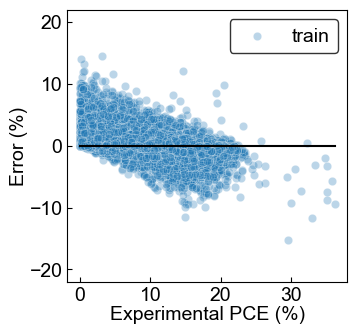

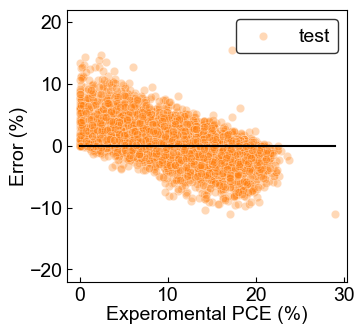

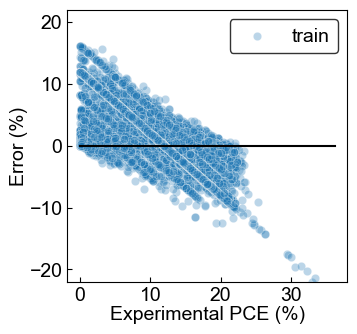

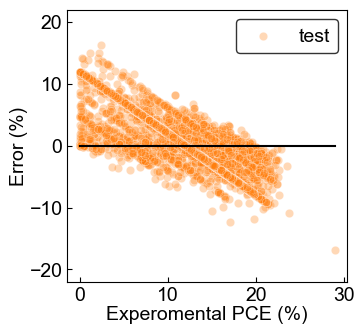

In [12]:
errorplot_train_ec("all", "RF", "sp1", "oliynyk", "zero", 0)
errorplot_test_ec("all", "RF", "sp1", "oliynyk", "zero", 0)
errorplot_train_ec("per", "RF", "sp0", "oliynyk", "dummy", 0)
errorplot_test_ec("per", "RF", "sp0", "oliynyk", "dummy", 0)

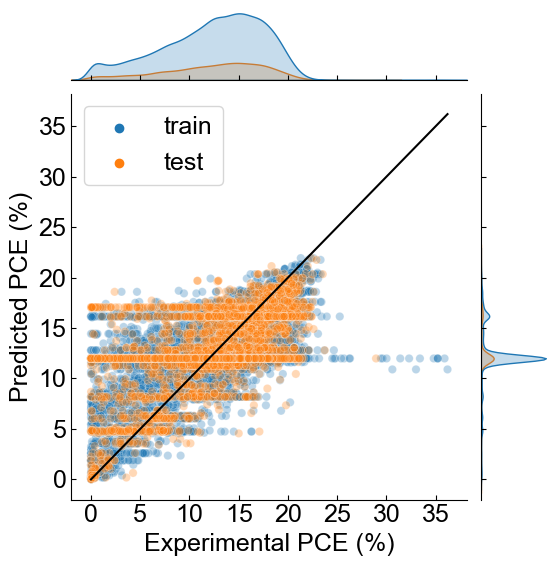

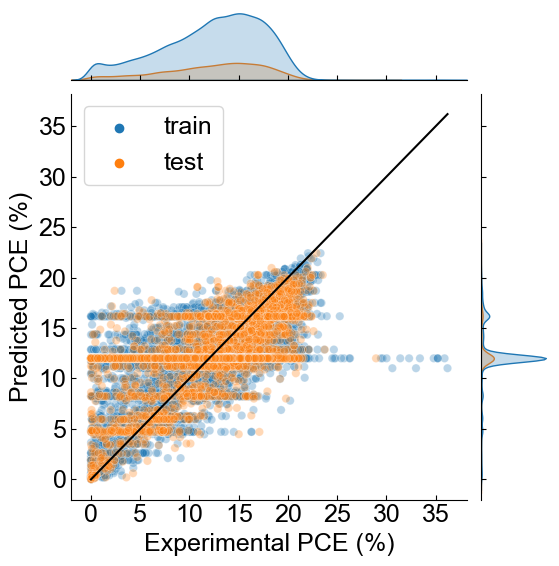

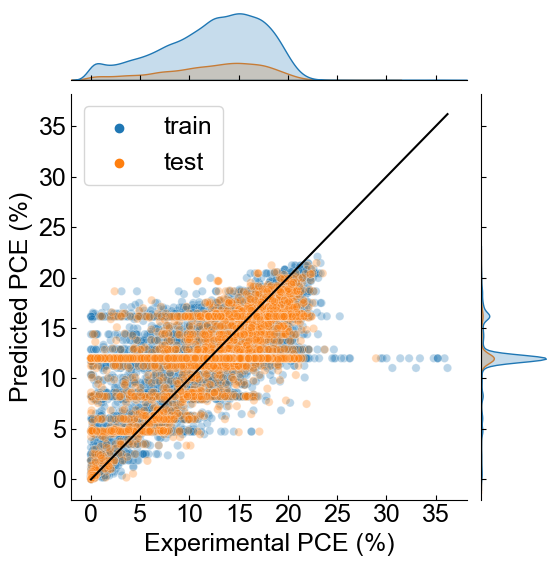

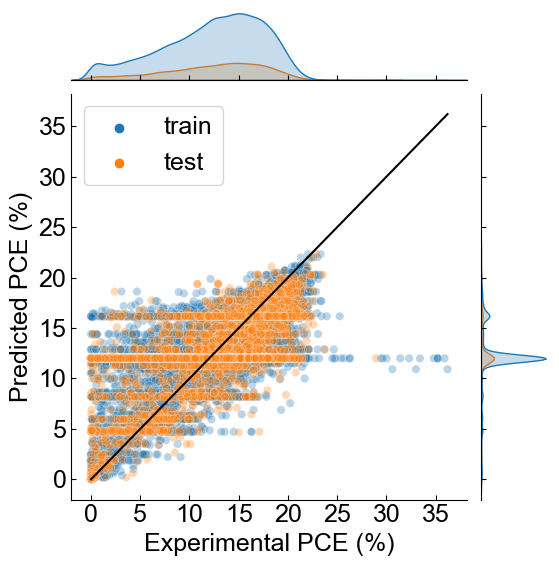

In [13]:
for prop in ["dummy", "oliynyk", "magpie", "mat2vec"]:
    jointplot("per", "RF", "sp0", prop,  "dummy", 0)

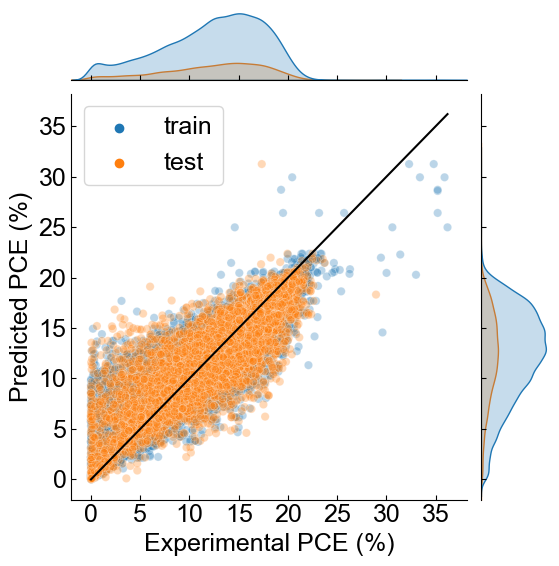

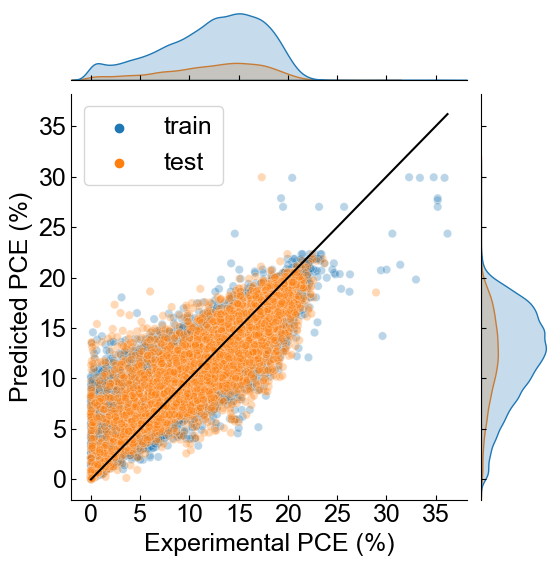

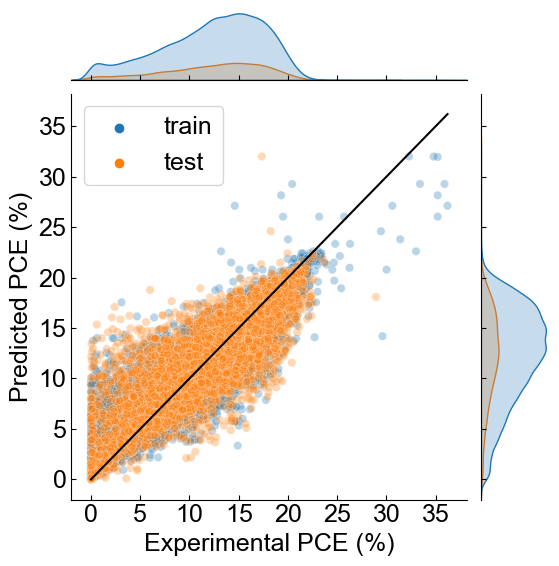

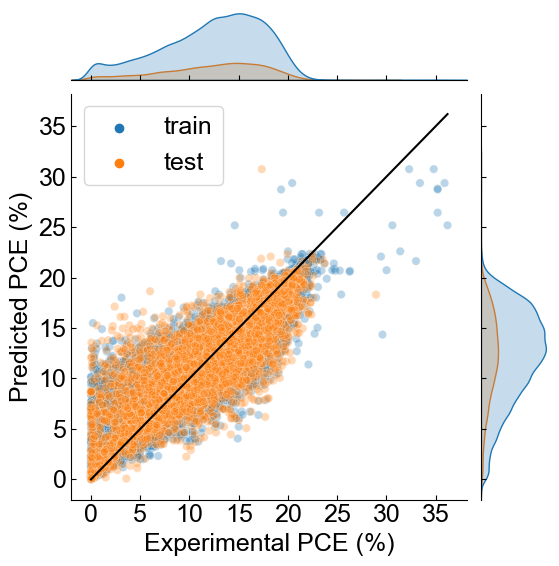

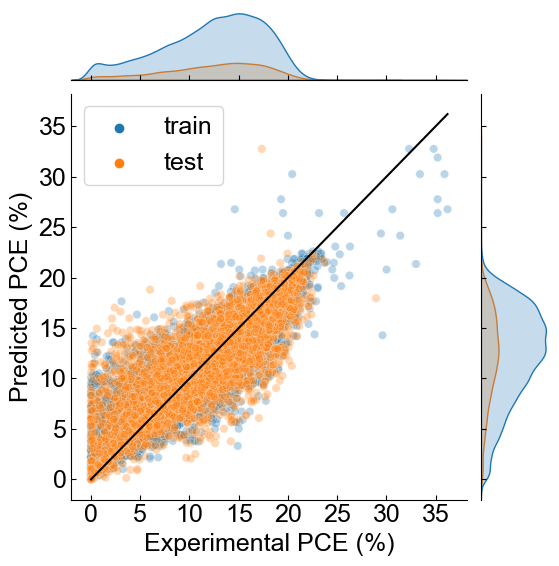

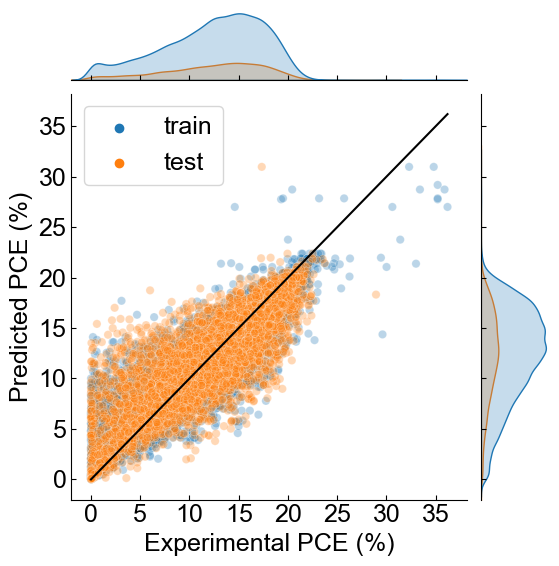

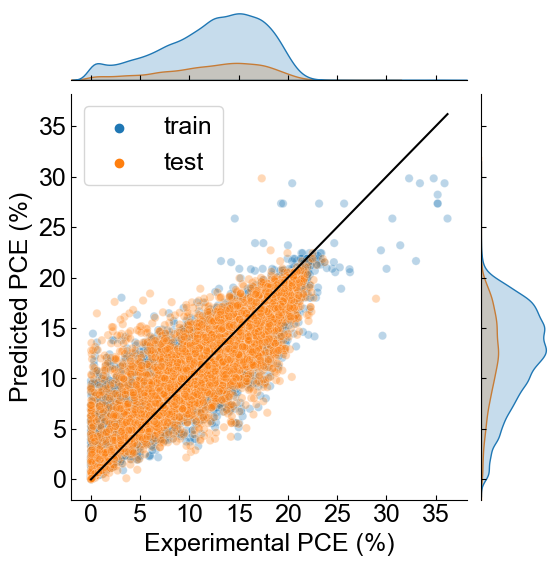

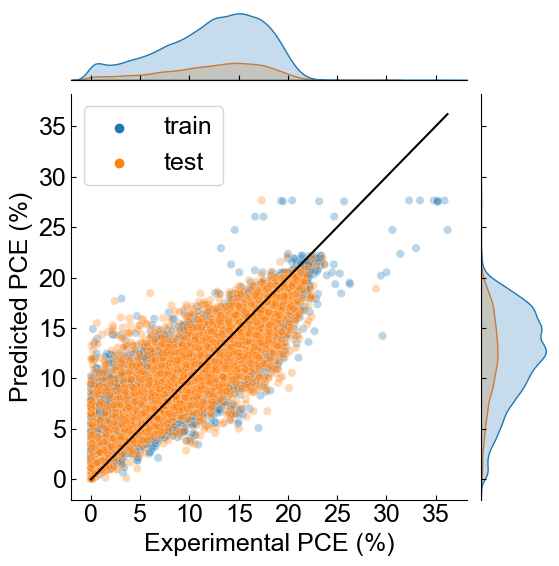

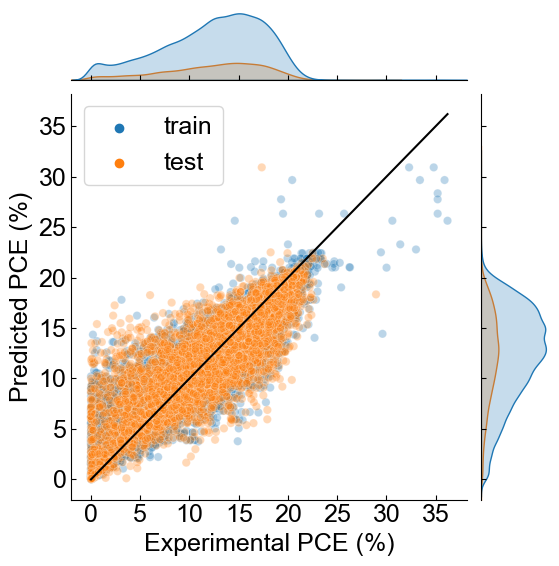

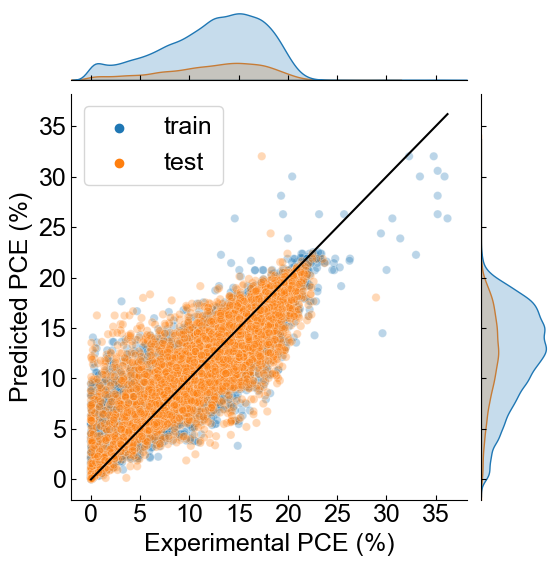

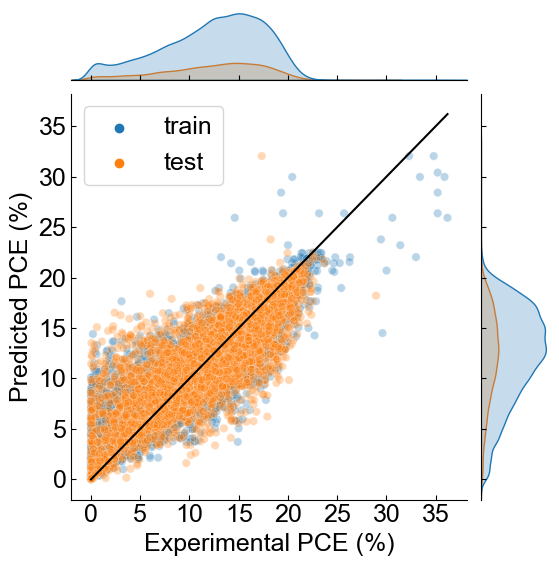

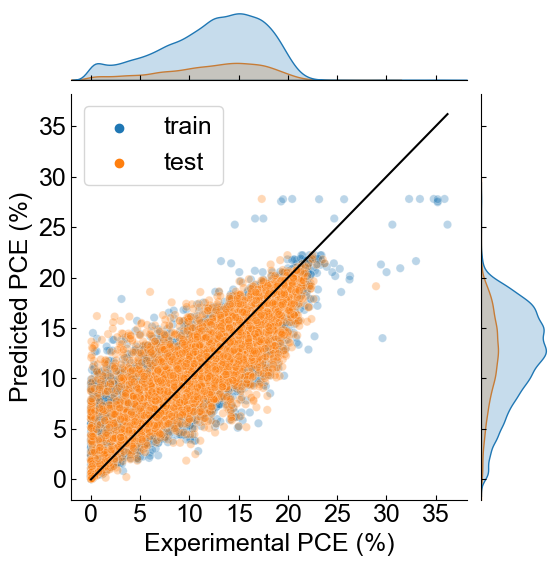

In [14]:
for split in ["sp0", "sp1", "sp2", "sp3"]:
    for fill in ["dummy", "zero", "median"]:
        jointplot("all", "RF", split, "oliynyk",  fill, 0)

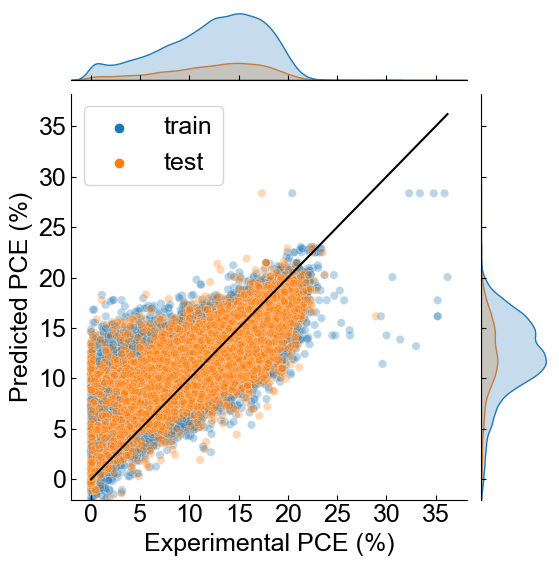

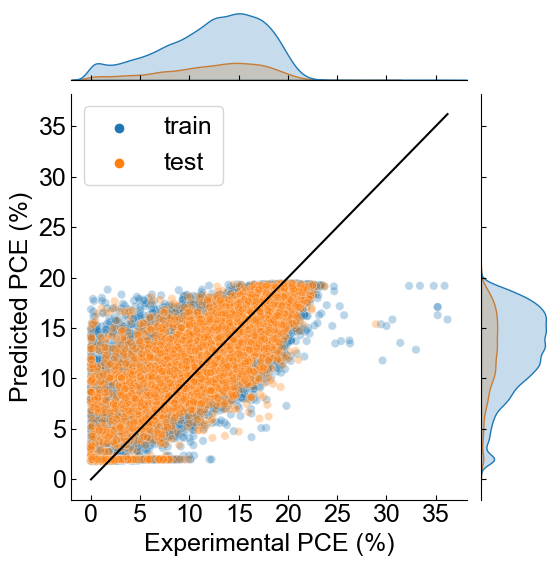

In [15]:
for model in ["GBDT", "NN"]:
    jointplot("all", model, "sp1", "oliynyk",  "zero", 0)

# Some scatter plots

In [9]:
y = pd.read_csv("data/raw/Perovskite_36937data.csv")["JV_default_PCE"]
X = csr2vec("data/csr/all_sp1_oliynyk_zero_csr.npz",
            "data/csr/all_sp1_oliynyk_zero_columns.npy")

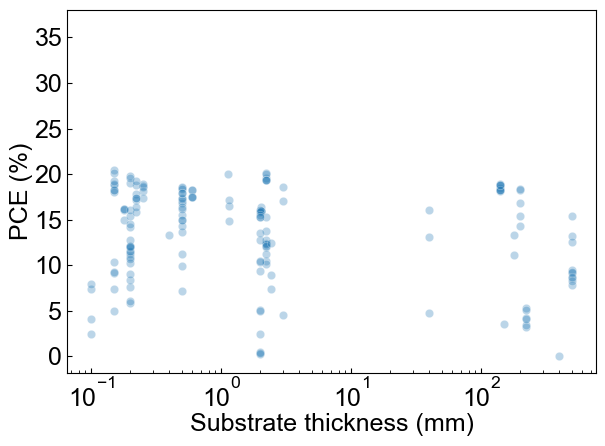

In [12]:
plt.rcParams['font.family'] ='Arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 18
plt.xlabel("Substrate thickness (mm)", labelpad =1)
plt.ylabel("PCE (%)", labelpad =1)
plt.locator_params(axis='x',nbins=10)
plt.locator_params(axis='y',nbins=10)
plt.scatter(X["Substrate_thickness"], PCE, alpha=0.3, label="test", ec='white',linewidths=0.5)
plt.xscale('log')
plt.tight_layout()
plt.savefig("PCE_vs_S_thick.png",dpi=300)

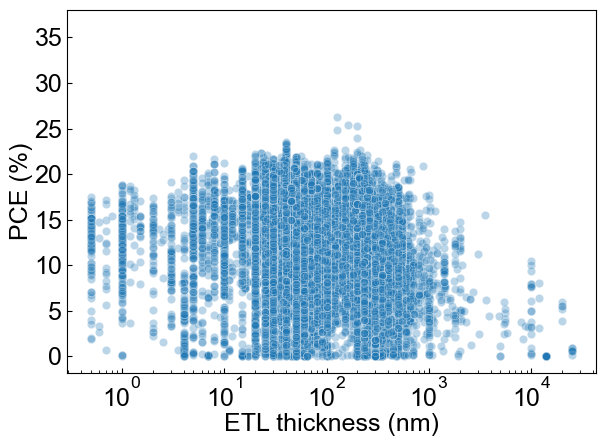

In [13]:
plt.rcParams['font.family'] ='Arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 18
plt.xlabel("ETL thickness (nm)", labelpad =1)
plt.ylabel("PCE (%)", labelpad =1)
plt.scatter(X["ETL_thickness"], PCE, alpha=0.3, label="test", ec='white',linewidths=0.5)
plt.locator_params(axis='x',nbins=20)
plt.locator_params(axis='y',nbins=10)
plt.xscale('log')
plt.tight_layout()
plt.savefig("PCE_vs_E_thick.png",dpi=300)

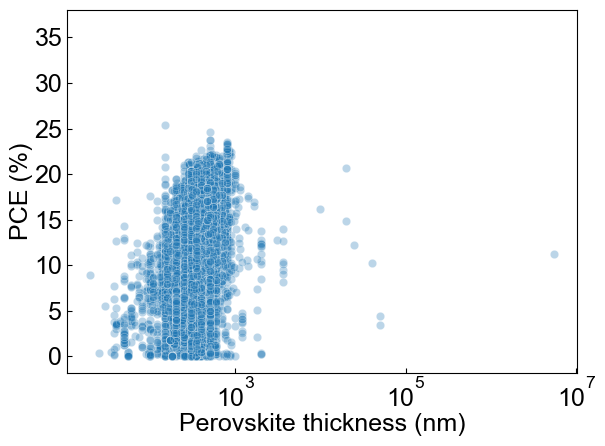

In [14]:
plt.rcParams['font.family'] ='Arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 18
plt.xlabel("Perovskite thickness (nm)", labelpad =1)
plt.ylabel("PCE (%)", labelpad =1)
plt.scatter(X["Perovskite_thickness"], PCE, alpha=0.3, label="test", ec='white',linewidths=0.5)
plt.locator_params(axis='x',nbins=20)
plt.locator_params(axis='y',nbins=10)
plt.xscale('log')
plt.tight_layout()
plt.savefig("PCE_vs_P_thick.png",dpi=300)

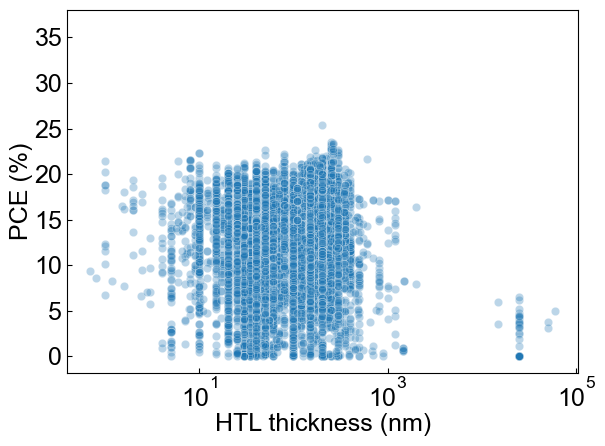

In [15]:
plt.rcParams['font.family'] ='Arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 18
plt.xlabel("HTL thickness (nm)", labelpad =1)
plt.ylabel("PCE (%)", labelpad =1)
plt.scatter(X["HTL_thickness_list"], PCE, alpha=0.3, label="test", ec='white',linewidths=0.5)
plt.locator_params(axis='x',nbins=20)
plt.locator_params(axis='y',nbins=10)
plt.xscale('log')
plt.tight_layout()
plt.savefig("PCE_vs_H_thick.png",dpi=300)

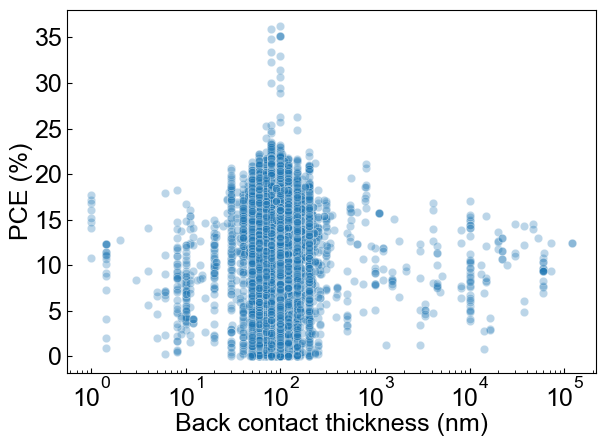

In [16]:
plt.rcParams['font.family'] ='Arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 18
plt.xlabel("Back contact thickness (nm)", labelpad =1)
plt.ylabel("PCE (%)", labelpad =1)
plt.scatter(X["Backcontact_thickness_list"], PCE, alpha=0.3, label="test", ec='white',linewidths=0.5)
plt.locator_params(axis='x',nbins=20)
plt.locator_params(axis='y',nbins=10)
plt.xscale('log')
plt.tight_layout()
plt.savefig("PCE_vs_B_thick.png",dpi=300)

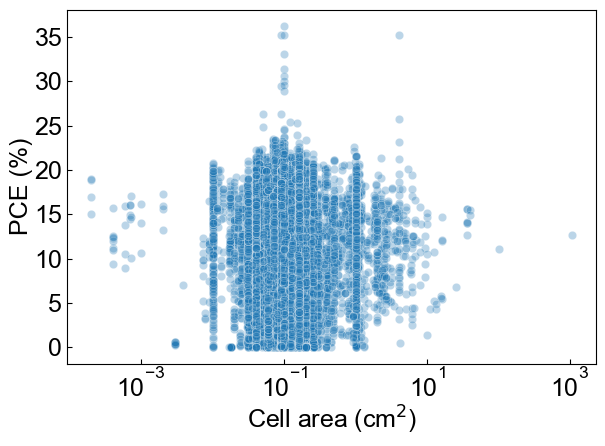

In [17]:
plt.rcParams['font.family'] ='Arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 18
plt.xlabel("Cell area (cm$^2$)", labelpad =1, verticalalignment='top')
plt.ylabel("PCE (%)", labelpad =1)
plt.scatter(X["Cell_area_measured"], PCE, alpha=0.3, label="test", ec='white',linewidths=0.5)
plt.locator_params(axis='x',nbins=20)
plt.locator_params(axis='y',nbins=10)
plt.xscale('log')
plt.tight_layout()
plt.savefig("PCE_vs_Area.png",dpi=300)